In [35]:
import datetime
import os
import time

import numpy as np
import torch
import torch.utils.data
from torch import nn
import torchvision
from torchvision.transforms import functional as F
from PIL import Image

import argparse


In [6]:
parser = argparse.ArgumentParser(description='PyTorch Segmentation Inference', add_help=True)

parser.add_argument('--model', default='fcn_resnet101', help='model')
parser.add_argument('--model-path', default='checkpoint.pth', help='path to the model checkpoint')
parser.add_argument('--device', default='cpu', help='device')
parser.add_argument('-i', '--input', default='test.jpg', help='file to infere')
parser.add_argument('-o', '--output', default='inference.png', help='output file')

_StoreAction(option_strings=['-o', '--output'], dest='output', nargs=None, const=None, default='inference.png', type=None, choices=None, help='output file', metavar=None)

In [7]:
class Args:
    def __init__(self) -> None:
        self.model = 'fcn_resnet101'
        self.model_path = 'checkpoint.pth'
        self.device = 'cpu'
        self.file = 'test.jpg'
        self.output = 'inference.png'
args = Args()

In [8]:

model = torchvision.models.segmentation.__dict__[args.model](
    num_classes=3
)
model.to(args.device)
checkpoint = torch.load(args.model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

<All keys matched successfully>

In [11]:
image = Image.open(args.file).convert('RGB')
image = F.resize(image, 100, interpolation=F.InterpolationMode.NEAREST)
image = F.to_tensor(image)[None,:,:,:]


In [48]:
with torch.no_grad():
    output = model(image)
    output = torch.nn.functional.softmax(output['out'], 1)[0,:,:,:]

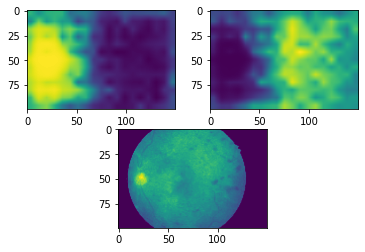

In [49]:
from matplotlib.pyplot import imshow, subplot

ax1 = subplot(212)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.imshow(image[0][0])

ax3 = subplot(222)
ax3.margins(2, 2)           # Values >0.0 zoom out
ax3.imshow(output[1])

ax2 = subplot(221)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.imshow(output[0])
